In [1]:
# This example simulates TXI beamline for a Gaussian source and illustrates following cases:
# 1. Ideal mirrors
# 2. Including mirror imperfection
# 3. Modeling KB mirrors as thin lenses ( fast simulation)
# 4. Modeling KB as an extended objects ( time consuming)
# 5. Effect of KB misalignment on focusing when treating KBs as extended objects 

# This script is created by Jacek Krzywinski and modified by Juncheng E to read files in DEMO paths.

In [33]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
wpg_path = '/gpfs/exfel/data/user/juncheng/WPG/'
sys.path.insert(0,wpg_path)

In [30]:
import time
import copy
import numpy as np
import pylab as plt

import wpg

#import SRW core functions
from wpg.srwlib import srwl,SRWLOptD,SRWLOptA,SRWLOptC,SRWLOptT,SRWLOptL,SRWLOptMirEl

In [32]:
wpg.__file__

'/gpfs/exfel/data/user/juncheng/panoscProject/src/simex_platform/lib/python3.6/wpg/__init__.py'

In [4]:
#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

#import some helpers functions
from wpg.useful_code.wfrutils import calculate_fwhm_x, plot_wfront, calculate_fwhm_y, print_beamline, get_mesh
from wpg.useful_code.wfrutils import propagate_wavefront

#Import base wavefront class
from wpg import Wavefront
from wpg.beamline import Beamline
from wpg.optical_elements import Empty, Use_PP
#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy

In [5]:
plt.ion()

In [6]:
#Plotting
def plot_1d(profile, title_fig, title_x, title_y):
    plt.plot(profile[0], profile[1])
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.title(title_fig)
    plt.grid(True)


def plot_2d(amap, xmin, xmax, ymin, ymax, title_fig, title_x, title_y):
    plt.imshow(amap, extent=(ymin, ymax, xmin, xmax))
    plt.colorbar()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    plt.title(title_fig)

In [7]:
def _resample(wf, axis, data, x0, x1):
    if axis.lower()=='x':
        y = data[int(data.shape[0]/2),:]
        x = np.linspace(wf.params.Mesh.xMin, wf.params.Mesh.xMax, y.shape[0])
    elif axis.lower()=='y':
        y = data[:,int(data.shape[1]/2)]
        x = np.linspace(wf.params.Mesh.yMin, wf.params.Mesh.yMax, y.shape[0])
    else:
        raise ValueError(
            'Wrong axis {}, should be "x" or "y"'.format(axis))

    if not x0 is None:
        xmin = x0
    else:
        xmin = x[0]

    if not x1 is None:
        xmax = x1
    else:
        xmax = x[-1]

    x1 = np.linspace(xmin,xmax,len(y))
    y1 = np.interp(x1, x,y)
    return x1, y1

def intensity_cut(wf, axis, polarization, x0=None, x1=None):

    if polarization.lower()  == 'v' or polarization.lower() == 'vertical':
        pol = 'vertical'
    elif polarization.lower() == 'h' or polarization.lower() == 'horizontal':
        pol = 'horizontal'
    elif polarization.lower() == 't' or polarization.lower() == 'total':
        pol = 'total'
    else:
        raise ValueError(
            'Wrong polarization {}, should be "v" or "vertical"'+
            ' or "h" or "horizontal" or "t" or "total"'.format(polarization))

    data = wf.get_intensity(slice_number=0, polarization=pol)
    return _resample(wf, axis, data, x0, x1)

def phase_cut(wf, axis, polarization, x0=None, x1=None):

    if polarization.lower()  == 'v' or polarization.lower() == 'vertical':
        pol = 'vertical'
    elif polarization.lower() == 'h' or polarization.lower() == 'horizontal':
        pol = 'horizontal'
    else:
        raise ValueError(
            'Wrong polarization {}, should be "v" or "vertical" or "h" or "horizontal"'.format(polarization))

    data = wf.get_phase(slice_number=0, polarization=pol)
    return _resample(wf, axis, data, x0, x1)

In [8]:
#calculate source size from photon energy and FWHM angular divergence
def calculate_source_fwhm(ekev, theta_fwhm):
    wl = 12.39e-10/ekev
    k = 2 * np.sqrt(2*np.log(2))
    theta_sigma = theta_fwhm /k
    sigma0 = wl /(2*np.pi*theta_sigma)
    return sigma0*k

In [9]:
#calculate angular divergence using formula from CDR2011
def calculate_theta_fwhm_cdr(ekev,qnC):
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

In [10]:
#define optical path difference (OPD) from mirror profile, i.e.
#fill the struct opTrErMirr
#input:
#    mdatafile: an ascii file with mirror profile data
#    ncol:      number of columns in the file
#    delim:     delimiter between numbers in an row, can be space (' '), tab '\t', etc
#    Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
#    theta:     incidence angle
#    scale:     scaling factor for the mirror profile
def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    heightProfData = np.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    plt.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)') #@todo add the func def in on top of example

In [11]:
def defineEFM(orient,p,q,thetaEFM,theta0,lengthEFM):
    """
    A wrapper to a SRWL function SRWLOptMirEl() for defining a plane elliptical focusing mirror propagator

    :param Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param p:  the distance to two ellipsis centers
    :param q:  the distance to two ellipsis centers
    :param thetaEFM:  the design incidence angle in the center of the mirror
    :param theta0:    the "real" incidence angle in the center of the mirror
    :param lengthEFM: mirror length, [m]
    :return: the struct opEFM
    """
    if orient == 'x':     #horizontal plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM,
                            _nvx=np.cos(theta0), _nvy=0, _nvz=-np.sin(theta0), _tvx=-np.sin(theta0), _tvy=0,
                             _x=0, _y=0, _treat_in_out=1)
    elif orient == 'y': #vertical plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM,
                            _nvx=0, _nvy=np.cos(theta0), _nvz=-np.sin(theta0), _tvx=0, _tvy=-np.sin(theta0),
                             _x=0, _y=0, _treat_in_out=1)
    else:
        raise TypeError('orient should be "x" or "y"')
    return opEFM

In [12]:
# basic parameters used for defining the beamline and calculating photon source
qnC = 0.1                    # e-bunch charge, [nC]
ekev = 4.0                   # photon energy

thetaOM = 7.e-3    # angle of incidence for the offset mirror
d2m1 = 90.66       # distance to the first offset mirror
d2hkb = 119.75     #distance to the first HFM KB
thetaKB = 7.e-3     # angle of incidence for the KB mirrorsr
dhkb_foc = 3.5     # nominal focal length for HFM KB
dvkb_foc = 2.5      # nominal focal length for VFM KB
dhkb_vkb = dhkb_foc - dvkb_foc       # distance between centers of HFM and VFM
lengthOM=0.8        #length of the offset mirror
lengthKB=0.8        # length of the KB mirror

*****defining initial wavefront and writing electric field data to h5-file...
waist_fwhm [um], theta_fwhms [urad]: 29.285785725549683 4.6710057014212625
save hdf5: g4_0kev.h5


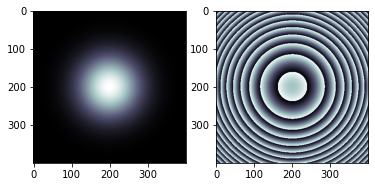

FWHMx [mm]: 0.41960936597414916
FWHMy [mm]: 0.41960936597414916
Coordinates of center, [mm]: 0.001577478819451755 0.001577478819451755
stepX, stepY [um]: 3.154957638903377 3.154957638903377 

R-space
FWHMx [mm], theta_fwhm [urad]: 0.41960936597414916 4.628384800067827


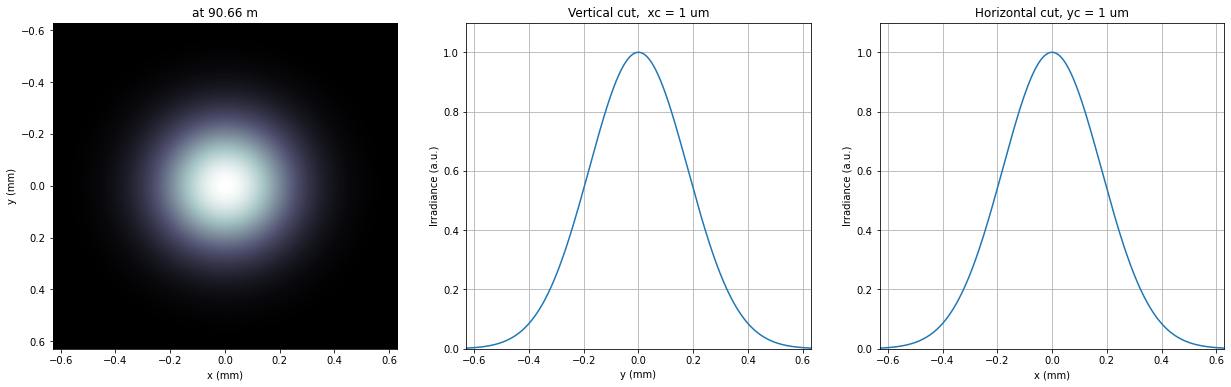

In [18]:
# #**********************Input Wavefront Structure and Parameters
print('*****defining initial wavefront and writing electric field data to h5-file...')
strInputDataFolder = 'wpg-samples/data_common'  # input data sub-folder name
strOutputDataFolder = './'  # output data sub-folder name

#init Gauusian beam parameters


z1 = d2m1
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('waist_fwhm [um], theta_fwhms [urad]:', sigX*k*1e6, theta_fwhm*1e6)
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size
npoints=400

#define unique filename for storing results
ip = np.floor(ekev)
frac = np.floor((ekev - ip)*1e3)
fname0 = 'g' + str(int(ip))+'_'+str(int(frac))+'kev'
print('save hdf5: '+fname0+'.h5')
ifname = os.path.join(strOutputDataFolder,fname0+'.h5')

#tiltX = theta_rms
#build SRW gauusian wavefront
wfr0=build_gauss_wavefront_xy(nx=npoints, ny=npoints, ekev=ekev,
                              xMin=-range_xy/2, xMax=range_xy/2,
                              yMin=-range_xy/2, yMax=range_xy/2,
                              sigX=sigX, sigY=sigX, d2waist=z1,
                              xoff=0, yoff=0, tiltX=0, tiltY=0)

#init WPG Wavefront helper class
mwf = Wavefront(wfr0)

#store wavefront to HDF5 file
mwf.store_hdf5(ifname)

#draw wavefront with common functions
plt.subplot(1,2,1)
plt.imshow(mwf.get_intensity(slice_number=0))
plt.subplot(1,2,2)
plt.imshow(mwf.get_phase(slice_number=0,polarization='horizontal'))
plt.show()

#draw wavefront with cuts
plot_wfront(mwf, title_fig='at '+str(z1)+' m',
            isHlog=False, isVlog=False,
            i_x_min=1e-5, i_y_min=1e-5, orient='x', onePlot=True)

plt.set_cmap('bone') #set color map, 'bone', 'hot', 'jet', etc
fwhm_x = calculate_fwhm_x(mwf)
print('FWHMx [mm], theta_fwhm [urad]:',fwhm_x*1e3,fwhm_x/z1*1e6)

*****Defining optical beamline from first offset mirror (M1) to exp hall
*****HOM1 data for BL1 beamline 


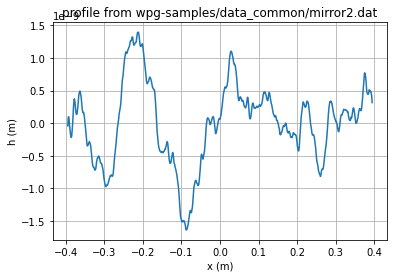

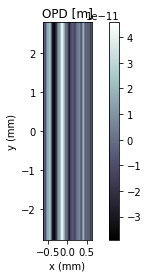

In [19]:
print('*****Defining optical beamline from first offset mirror (M1) to exp hall')

z2 = d2hkb - d2m1

DriftM1_KB = SRWLOptD(z2) #Drift from first offset mirror (M1) to exp hall
horApM1 = lengthOM*thetaOM
opApM1 = SRWLOptA('r', 'a', horApM1, range_xy)  # clear aperture of the Offset Mirror(s)
horApKB = lengthKB * thetaKB # Aperture of the KB system, CA 0.8 m
opApKB = SRWLOptA('r', 'a', horApKB, horApKB)  # clear aperture of the Offset Mirror(s)

#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#                 [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppM1 =            [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErM1 =        [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftM1_KB =    [ 0,  0, 1.0,  1,  0, 2.4, 1.8, 2.4, 1.8,  0,  0,   0]
ppApKB =          [ 0,  0, 1.0,  0,  0, 0.6, 8.0, 0.6, 4.0,  0,  0,   0]
ppHKB =           [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErHKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_HKB_foc = [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_KB =      [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppVKB =           [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppTrErVKB =       [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDrift_foc =     [ 0,  0, 1.0,  1,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
#ppFin  =          [ 0,  0, 1.0,  0,  0, 0.05,5.0, 0.05,5.0,  0,  0,   0]
ppFin =           [ 0,  0, 1.0,  0,  1, .01, 20.0, .01, 20.0,  0,  0,   0]

optBL0 = SRWLOptC([opApM1,  DriftM1_KB],
                    [ppM1,ppDriftM1_KB])

scale = 2     #5 mirror profile scaling factor
print('*****HOM1 data for BL1 beamline ')
opTrErM1 = SRWLOptT(1500, 100, horApM1, range_xy)
#defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
defineOPD(opTrErM1, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'x',  thetaOM, scale)
opdTmp=np.array(opTrErM1.arTr)[1::2].reshape(opTrErM1.mesh.ny,opTrErM1.mesh.nx)
plt.figure()
plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')

optBL1 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB],
                    [ppM1,ppTrErM1,ppDriftM1_KB])

dhkb_vkb = dhkb_foc - dvkb_foc          # distance between centers of HFM and VFM
d2vkb = d2hkb +  dhkb_vkb
vkbfoc =  1. /(1./dvkb_foc + 1. / d2vkb) # for thin lens approx
hkbfoc =  1. /(1./dhkb_foc + 1. / d2hkb) # for thin lens approx

z3 = dhkb_vkb
z4 = vkbfoc #distance to focal plane

#HKB = SRWLOptMirEl(_p=d2hkb, _q=dhkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=cos(thetaKB), _nvy=0, _nvz=-sin(thetaKB), _tvx=-sin(thetaKB), _tvy=0, _x=0, _y=0, _treat_in_out=1) #HKB Ellipsoidal Mirror
#VKB = SRWLOptMirEl(_p=d2vkb, _q=dvkb_foc, _ang_graz=thetaKB, _r_sag=1.e+40, _size_tang=0.85, _nvx=0, _nvy=cos(thetaKB), _nvz=-sin(thetaKB), _tvx=0, _tvy=-sin(thetaKB), _x=0, _y=0, _treat_in_out=1) #VKB Ellipsoidal Mirror
#HKB = SRWLOptL(hkbfoc) #HKB as Thin Lens
#VKB = SRWLOptL(1e23,vkbfoc) #VKB as Thin Lens
HKB = defineEFM('x', d2hkb, dhkb_foc, thetaKB, thetaKB, 0.85) #HKB Ellipsoidal Mirror
VKB = defineEFM('y', d2vkb, dvkb_foc, thetaKB, thetaKB, 0.85) #VKB Ellipsoidal Mirror
Drift_KB  = SRWLOptD(z3)
Drift_foc = SRWLOptD(z4)
optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc],
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB,ppDrift_foc,ppFin])

In [27]:
import h5py
print (ifname)

./g4_0kev.h5


In [26]:
with h5py.File(ifname,'r') as h5:
    for i in h5:
        print (i)
    print (h5['data'])

data
params
version
<HDF5 group "/data" (2 members)>


In [20]:
print('*****Imperfect HOM mirror, at KB aperture')
bPlotted = False
isHlog = True
isVlog = False
bSaved = True
optBL = optBL1
strBL = 'bl1'
pos_title = 'at exp hall wall'
print('*****setting-up optical elements, beamline:', strBL)
bl=Beamline(optBL)
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None

startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

*****Imperfect HOM mirror, at KB aperture
*****setting-up optical elements, beamline: bl1
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.005600000000000001
	Dy = 0.0012588280979224473
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0028000000000000004
		xStart = -0.0028000000000000004
		yFin = 0.0006294140489612237
		yStart = -0.0006294140489612237
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 29.090000000000003
	treat = 0
	

save hdf5: ./g4_0kev_bl1.h5
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0,

ValueError: value must be "arbitrary" or "sqrt(J/eV/mm^2)"or "sqrt(W/mm^2)" or "sqrt(Phot/s/0.1%bw/mm^2)"

In [ ]:
print('*****Imperfect HOM mirror, at KB aperture')
plot_wfront(mwf, 'at '+str(z1+z2)+' m',False, False, 1e-5,1e-5,'x', True)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')
print('FWHMx [mm], theta_fwhm [urad]:',calculate_fwhm_x(mwf)*1e3,calculate_fwhm_x(mwf)/(z1+z2)*1e6)
print('FWHMy [mm], theta_fwhm [urad]:',calculate_fwhm_y(mwf)*1e3,calculate_fwhm_y(mwf)/(z1+z2)*1e6)

In [ ]:
print('*****Focused beam: perfect KB')
bSaved = False
z3 = dhkb_vkb
z4 = dvkb_foc
z4 = vkbfoc #distance to focal plane


Drift_foc = SRWLOptD(dvkb_foc)

optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc],
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB,ppDrift_foc])
optBL = optBL2
strBL = 'bl2'
pos_title = 'at sample position'
print('*****setting-up optical elements, beamline:', strBL)
bl = Beamline(optBL)
bl.append(Empty(), Use_PP(zoom=0.02, sampling=5.0))
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None

startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

In [ ]:
bOnePlot = True
isHlog = False
isVlog = False
plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-5,1e-5,'x', bOnePlot)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')
print('FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6)

In [ ]:
print('*****HKB and VKB OPD from data  profiles ')
scale = 2 #scaling factor of mirror
opTrErHKB = SRWLOptT(1500, 100, horApKB, horApKB)
defineOPD(opTrErHKB, os.path.join(strInputDataFolder,'mirror1.dat'), 2, '\t', 'x',  thetaOM, scale)
opdTmp=np.array(opTrErHKB.arTr)[1::2].reshape(opTrErHKB.mesh.ny,opTrErHKB.mesh.nx)
plt.figure()
plot_2d(opdTmp, opTrErM1.mesh.xStart*1e3,opTrErM1.mesh.xFin*1e3,opTrErM1.mesh.yStart*1e3,opTrErM1.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')
print('*****VKB data  ')
opTrErVKB = SRWLOptT(100, 1500, horApKB, horApKB)
defineOPD(opTrErVKB, os.path.join(strInputDataFolder,'mirror2.dat'), 2, ' ', 'y',  thetaOM, scale)
opdTmp=np.array(opTrErVKB.arTr)[1::2].reshape(opTrErVKB.mesh.ny,opTrErVKB.mesh.nx)
plt.figure()
plot_2d(opdTmp, opTrErVKB.mesh.xStart*1e3,opTrErVKB.mesh.xFin*1e3,opTrErVKB.mesh.yStart*1e3,opTrErVKB.mesh.yFin*1e3,
        'OPD [m]', 'x (mm)', 'y (mm)')

In [16]:
print('*****Focused beam on focus: imperfect KB')
z3 = dhkb_vkb
z4 = dvkb_foc #distance to focal plane


HKB = SRWLOptL(hkbfoc) #HKB as Thin Lens
#VKB = SRWLOptL(1e23,vkbfoc) #VKB as Thin Lens
#HKB = defineEFM('x', d2hkb, dhkb_foc, thetaKB, thetaKB, 0.85) #HKB Ellipsoidal Mirror
#VKB = defineEFM('y', d2vkb, dvkb_foc, thetaKB, thetaKB, 0.85) #VKB Ellipsoidal Mirror
Drift_foc = SRWLOptD(z4)
optBL2 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,opTrErHKB,  Drift_KB,  VKB,opTrErVKB,  Drift_foc],
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppTrErM1,ppDrift_KB,ppVKB,ppTrErM1, ppDrift_foc])
optBL = optBL2
strBL = 'bl2'
pos_title = 'at sample position'
print('*****setting-up optical elements, beamline:', strBL)
bl = Beamline(optBL)
bl.append(Empty(), Use_PP(zoom=0.02, sampling=5.0))
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'_simex.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None

*****Focused beam on focus: imperfect KB


NameError: name 'opTrErHKB' is not defined

## Add extra fields required by WPG

In [34]:
def calculate_fwhm(wfr):
    """
    Calculate FWHM of the beam calculating number of point bigger then max/2 throuhgt center of the image

    :param wfr:  wavefront
    :return: {'fwhm_x':fwhm_x, 'fwhm_y': fwhm_y} in [m]
    """
    intens = wfr.get_intensity(polarization='total').sum(axis=-1);


    mesh = wfr.params.Mesh
    dx = (mesh.xMax-mesh.xMin)/mesh.nx
    dy = (mesh.yMax-mesh.yMin)/mesh.ny

    x_center = intens[intens.shape[0]//2,:]
    fwhm_x = len(x_center[x_center>x_center.max()/2])*dx

    y_center = intens[:,intens.shape[1]//2]
    fwhm_y = len(y_center[y_center>y_center.max()/2])*dy
    return {'fwhm_x':fwhm_x, 'fwhm_y': fwhm_y}

def add_custom_data(wf, bl0):
    """ Utility to store additional info on the wavefront . """

    # Add more metadata.
    fwhm = calculate_fwhm(wf)
    wf.custom_fields['/misc/xFWHM'] = fwhm['fwhm_x']
    wf.custom_fields['/misc/yFWHM'] = fwhm['fwhm_y']
    wf.custom_fields['/params/beamline/printout'] = str(bl0)

In [35]:
startTime = time.time()
mwf = propagate_wavefront(ifname, bl)
add_custom_data(mwf, bl)
mwf.store_hdf5(out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.005600000000000001
	Dy = 0.0012588280979224473
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0028000000000000004
		xStart = -0.0028000000000000004
		yFin = 0.0006294140489612237
		yStart = -0.0006294140489612237
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 29.090000000000003
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 0.6, 8.0, 0.6, 4.0, 0, 0, 0]
	Dx = 0.005600000000000001
	Dy = 0.005600000000000001
	ap_or_ob = a
	shape = r
	x =

*****Focused beam behind focus: imperfect KB
FWHMx [mm]: 0.000924271601993746
FWHMy [mm]: 0.0006290741821499545
Coordinates of center, [mm]: -0.00012849629588696263 -0.00011160993554276099
stepX, stepY [um]: 0.004508641960945103 0.006764238517741446 

R-space
zero-size array to reduction operation minimum which has no identity
FWHMx [um], FWHMy [um]: 0.924271601993746 0.6290741821499545


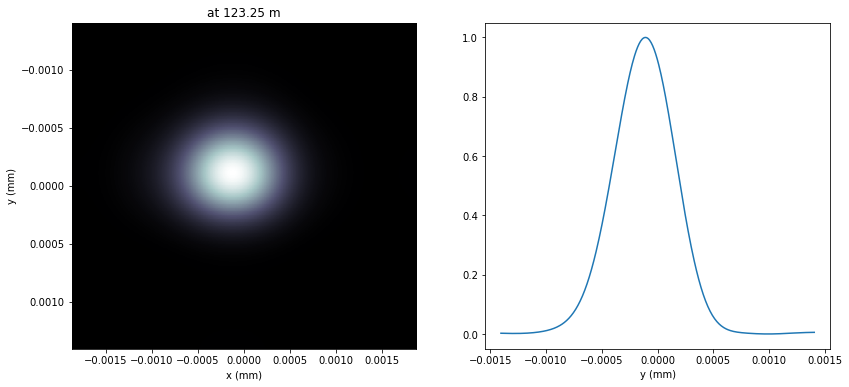

In [36]:
print('*****Focused beam behind focus: imperfect KB')
bOnePlot= True
isHlog = False
isVlog = False
bSaved = True
try:
    plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-3,1e-3,'x', bOnePlot)
except ValueError as e:
    print(e)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')
print('FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6)

## misaligned perfect KB

In [22]:
print('*****Focused beam behind focus: misaligned perfect KB')
z3 = dhkb_vkb
#z4 = dvkb_foc #distance to focal plane
theta0 = thetaKB + 150e-6
p = d2hkb
q = dhkb_foc
R0 = 2./(1./p+1./q)/thetaKB
q_mis = 1./(2/(R0*theta0)-1./p)
offset = q_mis - q #79e-3 if \Delta\theta 10 urad#0. if thetaKB0 = thetaKB
print('Distance to focus, without and with misalignment:', q,q_mis, 'm')
z4 = dvkb_foc+(q_mis-q) #distance to focal plane
Drift_foc = SRWLOptD(z4)
HKB = defineEFM('x', d2hkb, dhkb_foc, thetaKB, theta0, 0.85) #HKB Ellipsoidal Mirror
VKB = defineEFM('y', d2vkb, dvkb_foc, thetaKB, thetaKB, 0.85) #VKB Ellipsoidal Mirror
optBL4 = SRWLOptC([opApM1,opTrErM1,  DriftM1_KB,opApKB, HKB,   Drift_KB,  VKB,  Drift_foc],
                    [ppM1,ppTrErM1,ppDriftM1_KB,ppApKB,ppHKB,ppDrift_KB,ppVKB, ppDrift_foc])
optBL = optBL4
strBL = 'bl4'
pos_title = 'at new focal plane, misalidned KB angle:'+str(theta0)
print('*****setting-up optical elements, beamline:', strBL)
bl = Beamline(optBL)
bl.append(Empty(), Use_PP(zoom_h=0.2, sampling_h=5.0))
print(bl)

if bSaved:
    out_file_name = os.path.join(strOutputDataFolder, fname0+'_'+strBL+'.h5')
    print('save hdf5:', out_file_name)
else:
    out_file_name = None

startTime = time.time()
mwf = propagate_wavefront(ifname, bl,out_file_name)
print('propagation lasted:', round((time.time() - startTime) / 6.) / 10., 'min')

*****Focused beam behind focus: misaligned perfect KB
Distance to focus, without and with misalignment: 3.5 3.5772404428660955 m
*****setting-up optical elements, beamline: bl4
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.005600000000000001
	Dy = 0.0012588280979224473
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Transmission (generic)
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 1e+23
	Fy = 1e+23
	arTr = array of size 300000
	extTr = 0
	mesh = Radiation Mesh (Sampling)
		arSurf = None
		eFin = 0
		eStart = 0
		hvx = 1
		hvy = 0
		hvz = 0
		ne = 1
		nvx = 0
		nvy = 0
		nvz = 1
		nx = 1500
		ny = 100
		xFin = 0.0028000000000000004
		xStart = -0.0028000000000000004
		yFin = 0.0006294140489612237
		yStart = -0.0006294140489612237
		zStart = 0
	
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 1.8, 2.4, 1.8, 0, 0, 0]
	L = 29.090000000000003
	treat = 0
	
Optical E

*****Focused beam behind focus: misaligned ideal KB
FWHMx [mm]: 0.000910236044812934
FWHMy [mm]: 0.017426180306087002
Coordinates of center, [mm]: 0.000195378949012822 1.910765384443094e-05
stepX, stepY [um]: 0.004597151741479463 0.038215307688787274 

R-space
FWHMx [um], FWHMy [um]: 0.9102360448129341 17.426180306087


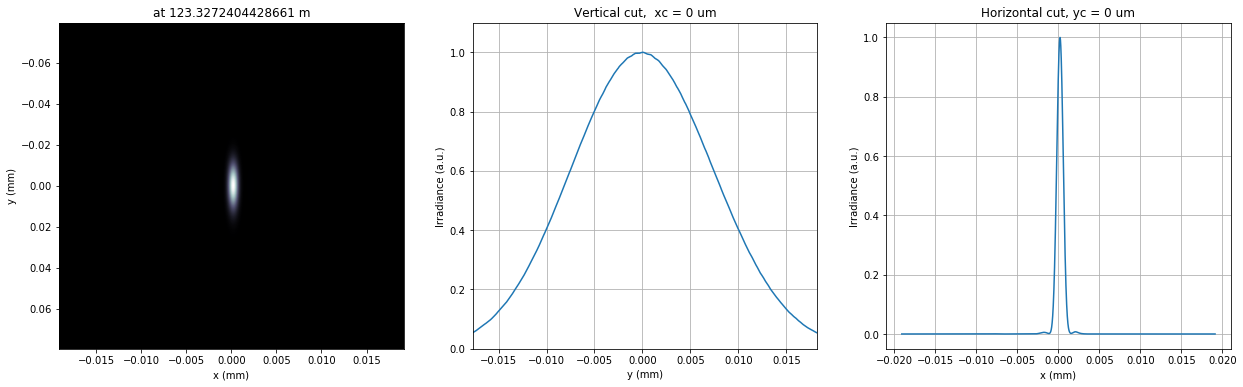

In [23]:
print('*****Focused beam behind focus: misaligned ideal KB')
pos_title = 'at new focal plane, misalidned KB angle:'+str(theta0)
bOnePlot= True
isHlog = False
isVlog = False
bSaved = True
plot_wfront(mwf, 'at '+str(z1+z2+z3+z4)+' m',isHlog, isVlog, 1e-3,1e-3,'x', bOnePlot)
#plt.set_cmap('bone') #set color map, 'bone', 'hot', etc
plt.axis('tight')
print('FWHMx [um], FWHMy [um]:',calculate_fwhm_x(mwf)*1e6,calculate_fwhm_y(mwf)*1e6)

at new focal plane, misalidned KB angle:0.00715


Text(0.5, 0, 'y [mm]')

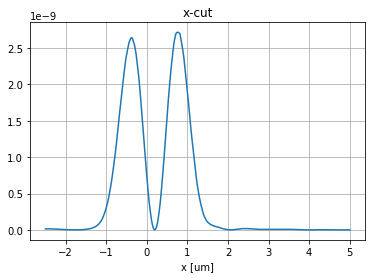

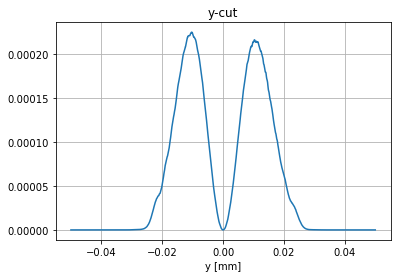

In [24]:
print('at new focal plane, misalidned KB angle:'+str(theta0))
x,y = intensity_cut(mwf, axis='x', polarization='v', x0=-2.5e-6, x1=5.e-6)
plt.figure()
plt.title('x-cut')
plt.plot(x*1e6,y) # x in [um]
plt.grid(True)
plt.xlabel('x [um]')

x,y = intensity_cut(mwf, axis='y', polarization='v', x0=-0.05e-3, x1=0.05e-3)
plt.figure()
plt.title('y-cut')
plt.plot(x*1e3,y) # x in [mm]
plt.grid(True)
plt.xlabel('y [mm]')